# <span id="chap_concepts_networks"></span> Graphs and networks

Everything in this book relates to networks. A *network* (or *graph*) is a collection of *nodes*, pairs of which are connected by *edges*. Sometimes nodes are referred to as *vertices* (and a single node is a *vertex*).

Refering to these structures as "graphs" is initially confusing for people who think of graphs as a plot of the relationships among two (or more) variables. It's especially confusing in this context, as we'll frequently be drawing this kind of graph when exploring the properties of the other kind of graph &ndash; the network. For this reason we'll try to use the term "network" for the node-and-edge structure, and keep "graph" for the line-and-error-bar structure. It's important to bear in mind, though, that terms like *network* and *graph* as well as *network science* and *graph theory*, can be used somewhat interchangeably.

The total number of nodes in the network is often referred to as the *order* of the network.

## <span id="sec_concepts_networks_adjacency"></span> Adjacency

The edges define the adjacencies of a network: two nodes are *adjacent* of there is an edge between them.

## <span id="sec_concepts_networks_simplest"></span> A simple network

TBC

In [13]:
import networkx as nx
import numpy as np

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn

## <span id="sec_concepts_networks_lattice"></span> Lattices

Perhaps the simplest kind of "real" network is a regular lattice or mesh. Think of a chess board, consisting of an eight-by-eight grid of squares. If we conside the intersections of the corners of the squares, with each other and with the edge of the board, forming the vertices of a 9x9 lattice. (An even better example is a [go board](https://en.wikipedia.org/wiki/Go_%28game%29), which is a 19x19 lattice of points on which one can play stones.)

We can write a Python function that will generate a lattice network in `NetworkX`: 

In [5]:
def lattice_graph( lattice_rows, lattice_columns ):
    """Create a regular 2D lattice with the given dimensions."""
    
    # create the graph and populate with nodes indexed by a single integer
    lattice = nx.Graph()
    lattice.add_nodes_from(xrange(lattice_rows * lattice_columns))
    
    # add edges to the main body of the lattice
    for r in xrange(0, lattice_rows - 1):             # sweep top-left to bottom-right
        for c in xrange(0,lattice_columns - 1):
            i = r * lattice_columns + c
            lattice.add_edge(i, i + 1)                # edge to right neighbour
            lattice.add_edge(i, i + lattice_columns)  # edge to south neighbour (row below)
        
    # add edges along the right-hand column
    for r in xrange(0, lattice_rows - 1):
        i = (r + 1) * lattice_columns - 1    
        lattice.add_edge(i, i + lattice_columns)      # edge to south neighbour (row below)
        
    # add edges along the bottom (south) edge
    for c in xrange(0, lattice_columns - 1):
        i = (lattice_rows - 1) * lattice_columns + c        
        lattice.add_edge(i, i + 1)                    # edge to right neighbour
        
    return lattice

Let's work through the process. Firstly we create an empty network and populate it with nodes. We then add edges. For all except the last column and row, we add an edge to the right and south neighbours: a moment's though should convince you that this fleshes out most of the lattice. We then add edges to complete the lattice in the final right-hand column and bottom row.

This is perhaps a slightly more involved process than you might have expected, but we have to be careful that we add all the edges we want *and no more*. Spefifically, although all the non-edge nodes have links going in four directions, there's only one edge between each pair of nodes, and we have to be careful not to add too many.

Notice how `NetworkX` manipulates the network. We add edge indices (integers in this case) and then use these to identify edges at the ends of edges.

We can now use our function to create a network with whatever dimensions we desire:

In [6]:
mesh = lattice_graph(10, 10)

What does the network look like? We can use `NetworkX` to visualise it, which in turn uses `matplotlib` to do the actually plotting:

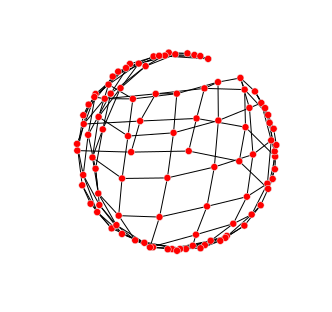

In [7]:
# create a figure with no axes
fig = plt.figure(figsize = (5, 5))   # an in-line figure
plt.gca().set_axis_off()             # turn off the axes, that mean nothing for networks

# use MetworkX to draw the network, without node labels
nx.draw_networkx(mesh, with_labels = False, node_size = 50)

It's kind of mesh-y, I suppose, but it doesn't really look much like a mesh as we usually imagine them &ndash; like a chessboard. We need to impose a *geometry* onto the *topology* of the network we've created, by placing the nodes at appropriate points in space. `NetworkX` has a default choice for topology called a "spring" layout that attempts to provide a "good" geometry.

In this case, what the layout consider to be a "good" geometry doesn't accord with our expectations, and so we'd be better off imposing our own. We need to define our own layout function. We'll actually do slightly more than this: we'll define a layout function that arranges the nodes in a grid, and then wrap this in a helper function we can call when we need it:

In [8]:
def lattice_positions( lattice, lattice_rows, lattice_columns ):
    """Return a dictionary of positions for nodes laid out in a lattice."""
    pos = dict()
    rh = 1.0 / (lattice_rows)           # row height
    cw = 1.0 / (lattice_columns)        # column width
    
    # run through the rows and columns, laying-out nodes as we go
    # and storing their co-ordinates into pos. Co-ordinates lie in
    # the range [0.0 ... 1.0]
    nodes = lattice.nodes_iter()
    try:
        for r in xrange(lattice_rows):
            for c in xrange(lattice_columns):
                n = nodes.next()
                pos[n] = (c * cw,
                          1.0 - r * rh) # lowest nodes in the top row, not the bottom
    except StopIteration:
        # ran out of nodes, so drop through
        pass
    
    return pos

def draw_lattice(g, lattice_rows = None, lattice_columns = None, **kwds):
    """Draw the graph with a lattice layout.
    
    g: the network to position
    lattice_rows: the number of rows in the lattice
    lattice_columns: the number of columns in the lattice
    """
    
    # fill in the argument defaults where not specified
    if lattice_rows is not None:
        if lattice_columns is None:
            # rows fixed, set the columns
            lattice_columns = g.order() / lattice_rows
            if g.order() % lattice_rows > 0:
                lattice_columns = lattice_columns + 1
    else:
        if lattice_columns is None:
            # neither rows nor columns fixed, set both
            lattice_rows = lattice_columns = int(np.sqrt(g.order()))
            if lattice_rows * lattice_columns < g.order():
                lattice_rows = lattice_rows + 1
        else:
            # columns fixed, set the rows
            lattice_rows = g.order() / lattice_columns
            if g.order() % lattice_columns > 0:
                lattice_rows = lattice_rows + 1

    # compute the layout using these dimensions
    pos = lattice_positions(g, lattice_rows, lattice_columns)
    
    # pass through the layout and any additional keyword arguments
    return nx.draw_networkx(g, pos, **kwds)

`matplotlib` plots diagrams using co-ordinates on the range $[0.0, 1.0]$ on both axes. The `lattice_positions` function simply divides this range evenly according to the numbers of rows and columns we want.  The `draw_lattice` function provides some useful defaults for deciding these dimensions: you can fix the number of rows and columns, either of them, or neither, and the function will pick default values itself.

We can then plot the lattice using this function:

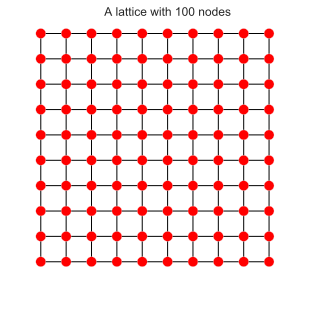

In [14]:
# set up a figure with a little tidying-up 
fig = plt.figure(figsize = (5, 5))
_ = plt.gca().set_axis_off()             # axes off
_ = plt.gca().set_xlim([-0.05, 1.05])    # add a little space around the plot
_ = plt.gca().set_ylim([-0.05, 1.05])
_ = plt.title("A lattice with {n} nodes".format(n = mesh.order()))

# draw the lattice
draw_lattice(mesh, with_labels = False, node_size = 100)

Much more intuitive.